### Task 1a

In [1]:
#Import libraries
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches

### 1. Load MRI Data

In [2]:
# ========= Load MRI Data ==========
nii_path = "mri_single_egg.nii"   # <--- update path if needed
img = nib.load(nii_path)
data = img.get_fdata()

print("Data shape:", data.shape)

Data shape: (36, 45, 80)


### 2.Data preprocessing --> Eliminate Background 
#### Thresholding is done based on histogram analysis

In [3]:
# ========= Background Mask ==========
#bg_thresh = np.percentile(data[data > data.min()], 1)  # very low threshold
bg_thresh = 0.17 #thresholding based on histogram analyis
mask = data > bg_thresh

### 3. Applying ML model :  K-Means clustering

In [4]:
# ========= KMeans Clustering ==========
flat = data[mask].reshape(-1, 1)
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42).fit(flat)

labels = np.full(data.shape, -1, dtype=int)
labels[mask] = kmeans.labels_

# ========= Reorder Clusters ==========
voxel_counts = [(i, np.sum(labels == i)) for i in range(3)]
voxel_counts.sort(key=lambda x: x[1], reverse=True)  # largest → smallest
idx_white, idx_yolk, idx_air = [c[0] for c in voxel_counts]


### 4. Volume estimation 
#### Further scaled to ground truth - 60ml

In [5]:
# ========= Volume Calculation ==========
voxel_dims = img.header.get_zooms()[:3]  # voxel size in mm
voxel_volume_mm3 = np.prod(voxel_dims)

vol_white_mm3 = np.sum(labels == idx_white) * voxel_volume_mm3
vol_yolk_mm3  = np.sum(labels == idx_yolk) * voxel_volume_mm3
vol_air_mm3   = np.sum(labels == idx_air) * voxel_volume_mm3

# Convert to mL
vol_white_ml = vol_white_mm3 / 1000
vol_yolk_ml  = vol_yolk_mm3 / 1000
vol_air_ml   = vol_air_mm3 / 1000

# Scale to ground truth total = 60 mL
total_ml = vol_white_ml + vol_yolk_ml + vol_air_ml
scale_factor = 60.0 / total_ml

scaled_white_ml = vol_white_ml * scale_factor
scaled_yolk_ml  = vol_yolk_ml * scale_factor
scaled_air_ml   = vol_air_ml * scale_factor

print("\n=== Volume Estimates (scaled to 60 mL total) ===")
print(f"Egg White: {scaled_white_ml:.2f} mL")
print(f"Yolk     : {scaled_yolk_ml:.2f} mL")
print(f"Air Cell : {scaled_air_ml:.2f} mL")
print(f"Total    : {scaled_white_ml + scaled_yolk_ml + scaled_air_ml:.2f} mL")




=== Volume Estimates (scaled to 60 mL total) ===
Egg White: 28.06 mL
Yolk     : 20.42 mL
Air Cell : 11.52 mL
Total    : 60.00 mL


### 5. Visualisation 

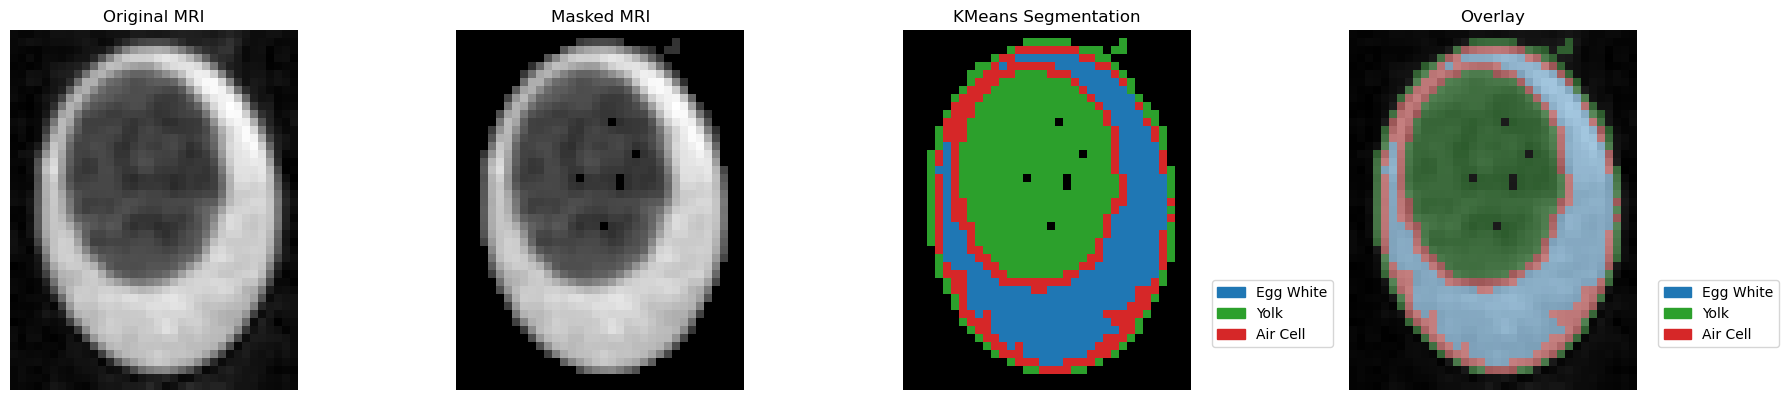

In [6]:
# ========= Visualization ==========
def show_slices(data, labels, slice_idx=None):
    if slice_idx is None:
        slice_idx = data.shape[2] // 2  # middle axial slice
    
    original = data[:, :, slice_idx]
    seg = labels[:, :, slice_idx]

    # Assign fixed colors for consistency
    cmap = plt.cm.tab10
    cluster_to_label = {
        idx_white: "Egg White",
        idx_yolk: "Yolk",
        idx_air: "Air Cell"
    }
    cluster_colors = {
        idx_white: cmap(0),   # blue
        idx_yolk:  cmap(2),   # green
        idx_air:   cmap(3)    # red/orange
    }

    # Build legend handles
    legend_patches = [
        mpatches.Patch(color=cluster_colors[idx_white], label="Egg White"),
        mpatches.Patch(color=cluster_colors[idx_yolk],  label="Yolk"),
        mpatches.Patch(color=cluster_colors[idx_air],   label="Air Cell")
    ]

    # Map segmentation to chosen colors
    seg_colored = np.zeros((*seg.shape, 3))
    for idx, color in cluster_colors.items():
        seg_colored[seg == idx] = color[:3]

    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    
    # Original MRI
    axes[0].imshow(np.rot90(original), cmap="gray")
    axes[0].set_title("Original MRI")
    axes[0].axis("off")

    # Masked MRI
    axes[1].imshow(np.rot90(original * mask[:, :, slice_idx]), cmap="gray")
    axes[1].set_title("Masked MRI")
    axes[1].axis("off")
    
    # Segmentation
    axes[2].imshow(np.rot90(seg_colored))
    axes[2].set_title("KMeans Segmentation")
    axes[2].axis("off")
    axes[2].legend(handles=legend_patches, loc="lower left", bbox_to_anchor=(1.05, 0.1))
    
    # Overlay
    axes[3].imshow(np.rot90(original), cmap="gray")
    axes[3].imshow(np.rot90(seg_colored), alpha=0.4)
    axes[3].set_title("Overlay")
    axes[3].axis("off")
    axes[3].legend(handles=legend_patches, loc="lower left", bbox_to_anchor=(1.05, 0.1))
    
    plt.tight_layout()
    plt.show()

# Show mid-slice visualization
show_slices(data, labels)

    

# Task 1a Report : 

## Results
- The MRI data was successfully loaded and preprocessed.  
- Background voxels (intensity < 0.18) were eliminated   
- KMeans clustering was applied to separate into 3 regions - egg yolk, white and air cell.
- Volume was estimated and scaled to ground truth


## Assumptions
1. **Background Removal:**  
   - A global intensity threshold was assumed based on histogram analysis. 
   - This assumes consistent intensity scaling across the MRI volume, which may not hold true in all cases.
   - This assumption can lead to some regions within the egg be eliminated as background

2. **Clustering (KMeans):**  
   - Intensity values were assumed sufficient to differentiate different regions.
   - Based on an egg's anatomy : egg white is considered to have highest volume.
    
   
## Scalability 
- For higher-resolution 3D MRIs, direct clustering based on intensity becomes impractical. Downsampling or GPU-accelerated implementations are needed for large datasets.
  